In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import time
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.models import resnet18
from torch.nn import functional as F

torch.cuda.empty_cache()

# Fixing HTTP 403 Error
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [2]:
preprocess_cifar = transforms.Compose(
            [transforms.ToTensor(), 
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_train_set = torchvision.datasets.CIFAR10(root='./cifar_train', train=True, download=True, transform=preprocess_cifar)
cifar_test_set = torchvision.datasets.CIFAR10(root='./cifar_test', train=False, download=True, transform=preprocess_cifar)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./cifar_train/cifar-10-python.tar.gz to ./cifar_train


Extracting ./cifar_test/cifar-10-python.tar.gz to ./cifar_test


In [3]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25]),
])

# Initialise train and validation sets applying normalisation
MNIST_train_set = datasets.MNIST('mnist_train', download=True, train=True, transform=preprocess)
MNIST_val_set = datasets.MNIST('mnist_test', download=True, train=False, transform=preprocess)

Extracting mnist_train/MNIST/raw/train-images-idx3-ubyte.gz to mnist_train/MNIST/raw


Extracting mnist_train/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_train/MNIST/raw


Extracting mnist_train/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_train/MNIST/raw


Extracting mnist_train/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_train/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting mnist_test/MNIST/raw/train-images-idx3-ubyte.gz to mnist_test/MNIST/raw


Extracting mnist_test/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_test/MNIST/raw


Extracting mnist_test/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_test/MNIST/raw


Extracting mnist_test/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_test/MNIST/raw
Processing...
Done!


In [13]:
class Net():
    
    def __init__(self):
        # Initialise the model
        model = resnet18(num_classes=10, pretrained=False)
        #model = torch.hub.load('pytorch/vision:v0.6.0', 'wide_resnet50_2', pretrained=False)
        #model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model = model.cuda()

    def mixup(self, data, target, alpha):
        lmbd = np.random.beta(alpha, alpha)
        batch_size = data.size()[0]
        shuffle = torch.randperm(batch_size)
        target_shuffled = target[shuffle]
        data_mixup = lmbd * data + (1 - lmbd) * data[shuffle, :]
        return data_mixup, target, target_shuffled, lmbd

    def mixup_criterion(self, preds, target, target_shuffled, lmbd):
        return lmbd * self.criterion(preds, target) + (1 - lmbd) * self.criterion(preds, target_shuffled)

    def test(self, test_set):
        self.model.eval()
        total = 0
        correct = 0
        test_loss = 0
        for batch_idx, (images, labels) in enumerate(test_set):
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            outputs = self.model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = self.criterion(outputs, labels)
            test_loss += loss.item()
            n_batches = batch_idx
        test_loss = test_loss / n_batches
        print(f'Test loss: {np.round(test_loss, 4)}')
        print(f'Test accuracy: {100 * correct / total}')
        print('-------------------')

    def train(self, train_set, val_set, alpha, epochs=10, with_mixup=False):
        self.model.train()
        self.train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True)

        optimizer = optim.SGD(self.model.parameters(), lr=0.003, momentum=0.9)
        self.criterion = nn.CrossEntropyLoss()
        for e in range(epochs):
            epoch_start = time.perf_counter()
            self.model.train()
            running_loss = 0
            for i, (images, labels) in enumerate(self.train_loader):
                if torch.cuda.is_available():
                  images, labels = images.cuda(), labels.cuda()

                # Training pass
                optimizer.zero_grad()

                if with_mixup:
                  images, labels, labels_shuffled, lmbd = self.mixup(images, labels, alpha)
                  outputs = self.model(images)
                  loss = self.mixup_criterion(outputs, labels, labels_shuffled, lmbd)
                else:
                  outputs = self.model(images)
                  loss = self.criterion(outputs, labels)

                # Backpropagation
                loss.backward()

                # Optimisation
                optimizer.step()

                running_loss += loss.item()
                batches = i
            epoch_end = time.perf_counter()
            print(f'Epoch {e} - Training loss: {np.round(running_loss/batches, 4)}; time spent: {np.round(epoch_end - epoch_start, 2)} seconds')
            self.test(self.val_loader)

    def predict(self, data):
      with torch.no_grad():
        outs = self.model(data)
      return outs


    
def compute_ece_loss(classifier_output, labels, n_gaps):
  gap_boundaries = torch.linspace(0, 1, n_gaps + 1)
  gap_lowers = gap_boundaries[:-1]
  gap_uppers = gap_boundaries[1:]
  confidences, predictions = torch.max(classifier_output, 1)
  accuracies = predictions.eq(labels)
  ece = torch.zeros(1)
  confidences_pl = []
  accuracies_pl = []
  for gap_lower, gap_upper in zip(gap_lowers, gap_uppers):
    relevant_samples = confidences.gt(gap_lower.item()) * confidences.le(gap_upper.item())
    prop_relevant_samples = relevant_samples.float().mean()
    if prop_relevant_samples.item() > 0:
      accuracy_relevant_samples = accuracies[relevant_samples].float().mean()
      avg_confidence_relevant_samples = confidences[relevant_samples].mean()
      ece += torch.abs(avg_confidence_relevant_samples - accuracy_relevant_samples) * prop_relevant_samples
      confidences_pl.append(confidences[relevant_samples].mean())
      accuracies_pl.append(accuracies[relevant_samples].float().mean())
  return ece, confidences_pl, accuracies_pl

def plot_con_acc(con, acc):
  fig, ax = plt.subplots()
  ax.scatter(con, acc)
  x = np.arange(0.0, 1.0, 0.01)
  s = x
  ax.plot(x,s, 'r--')
  ax.set(ylabel='accuracy (%)', xlabel='confidence (%)',
    title='accuracy/confidence plot')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.savefig('foo.pdf')
  plt.show()

def evaluate_calibration(data, model, amount):
  val_set = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)
  i=0
  with torch.no_grad():
    for images, labels in val_set:
      if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()
      if i == 0:
        all_prediction = torch.exp(model.predict(images))
        all_labels = labels
      else: 
        all_prediction = torch.cat((all_prediction, F.softmax(model.predict(images))),0)
        all_labels = torch.cat((all_labels, labels),0)
      i+=1
  ece, con, acc = compute_ece_loss(all_prediction.to("cpu"), all_labels.to("cpu"), amount)
  for i in range(len(acc)):
    acc[i]=acc[i].numpy()
  for i in range(len(con)):
    con[i]=con[i].detach().numpy()
  plot_con_acc(con, acc)
  print(ece.item())

Epoch 0 - Training loss: 1.7907; time spent: 30.12 seconds
Test loss: 1.3806
Test accuracy: 50.97
-------------------
Epoch 1 - Training loss: 1.4922; time spent: 29.75 seconds
Test loss: 1.1687
Test accuracy: 59.5
-------------------
Epoch 2 - Training loss: 1.3958; time spent: 29.74 seconds
Test loss: 1.0943
Test accuracy: 62.49
-------------------
Epoch 3 - Training loss: 1.2787; time spent: 29.94 seconds
Test loss: 1.0526
Test accuracy: 64.06
-------------------
Epoch 4 - Training loss: 1.1946; time spent: 29.75 seconds
Test loss: 1.0273
Test accuracy: 65.23
-------------------
Epoch 5 - Training loss: 1.1302; time spent: 29.95 seconds
Test loss: 0.9854
Test accuracy: 66.68
-------------------
Epoch 6 - Training loss: 1.0487; time spent: 29.81 seconds
Test loss: 0.9501
Test accuracy: 68.11
-------------------
Epoch 7 - Training loss: 0.996; time spent: 29.73 seconds
Test loss: 0.9185
Test accuracy: 69.42
-------------------
Epoch 8 - Training loss: 0.9486; time spent: 29.85 seconds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


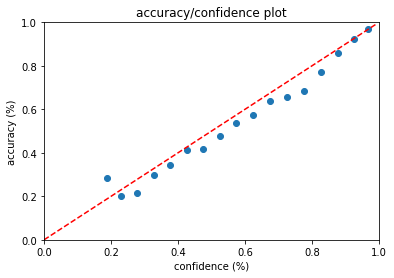

0.03127700835466385


In [16]:
model_cifar = Net()
model_cifar.train(cifar_train_set, cifar_test_set, with_mixup=True, alpha=.3, epochs=15)
evaluate_calibration(cifar_test_set, model_cifar, amount=20)

Epoch 0 - Training loss: 1.7049; time spent: 29.98 seconds
Test loss: 1.3301
Test accuracy: 52.92
-------------------
Epoch 1 - Training loss: 1.3996; time spent: 30.19 seconds
Test loss: 1.1671
Test accuracy: 59.16
-------------------
Epoch 2 - Training loss: 1.2612; time spent: 29.66 seconds
Test loss: 1.0652
Test accuracy: 64.26
-------------------
Epoch 3 - Training loss: 1.1529; time spent: 29.88 seconds
Test loss: 0.9775
Test accuracy: 66.81
-------------------
Epoch 4 - Training loss: 1.0838; time spent: 29.98 seconds
Test loss: 1.0462
Test accuracy: 64.89
-------------------
Epoch 5 - Training loss: 0.9812; time spent: 29.67 seconds
Test loss: 0.9017
Test accuracy: 69.82
-------------------
Epoch 6 - Training loss: 0.9341; time spent: 29.97 seconds
Test loss: 0.9292
Test accuracy: 69.02
-------------------
Epoch 7 - Training loss: 0.9175; time spent: 29.77 seconds
Test loss: 0.9815
Test accuracy: 67.5
-------------------
Epoch 8 - Training loss: 0.8413; time spent: 29.86 second

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


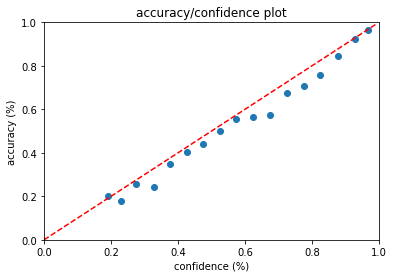

0.032036010175943375


In [17]:
model_cifar = Net()
model_cifar.train(cifar_train_set, cifar_test_set, with_mixup=True, alpha=.2, epochs=15)
evaluate_calibration(cifar_test_set, model_cifar, amount=20)

Epoch 0 - Training loss: 1.8425; time spent: 30.21 seconds
Test loss: 1.3949
Test accuracy: 51.37
-------------------
Epoch 1 - Training loss: 1.6122; time spent: 29.92 seconds
Test loss: 1.2528
Test accuracy: 56.71
-------------------
Epoch 2 - Training loss: 1.4776; time spent: 29.55 seconds
Test loss: 1.1774
Test accuracy: 60.67
-------------------
Epoch 3 - Training loss: 1.3736; time spent: 29.83 seconds
Test loss: 1.0538
Test accuracy: 64.31
-------------------
Epoch 4 - Training loss: 1.3192; time spent: 29.88 seconds
Test loss: 1.044
Test accuracy: 64.36
-------------------
Epoch 5 - Training loss: 1.2601; time spent: 30.18 seconds
Test loss: 0.9638
Test accuracy: 68.2
-------------------
Epoch 6 - Training loss: 1.2389; time spent: 29.82 seconds
Test loss: 1.0013
Test accuracy: 67.34
-------------------
Epoch 7 - Training loss: 1.1705; time spent: 29.98 seconds
Test loss: 0.9221
Test accuracy: 69.54
-------------------
Epoch 8 - Training loss: 1.1223; time spent: 30.03 seconds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


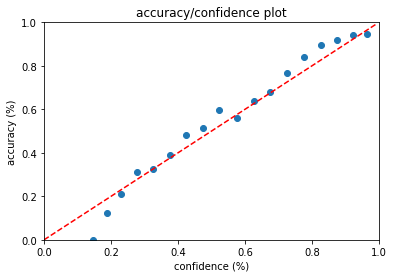

0.03844597935676575


In [18]:
model_cifar = Net()
model_cifar.train(cifar_train_set, cifar_test_set, with_mixup=True, alpha=.5, epochs=15)
evaluate_calibration(cifar_test_set, model_cifar, amount=20)

In [ ]:
model = Net()
model.train(MNIST_train_set, MNIST_val_set, with_mixup=True, alpha=.4, epochs=10)

Epoch 0 - Training loss: 0.8414876622087227; time spent: 207.34259460099975 seconds
Test loss: 0.12090687678219417
Epoch 1 - Training loss: 0.5762152373552195; time spent: 207.1980855959996 seconds
Test loss: 0.21063826662989762
Epoch 2 - Training loss: 0.5246381638343014; time spent: 208.20982416700008 seconds
Test loss: 0.06707044729055503
Epoch 3 - Training loss: 0.4852675210998623; time spent: 207.34098636099998 seconds
Test loss: 0.06191363278776407
Epoch 4 - Training loss: 0.49682942280802267; time spent: 206.85355453900002 seconds
Test loss: 0.0711293933698191
Epoch 5 - Training loss: 0.4549076348431846; time spent: 206.2756513700001 seconds
Test loss: 0.0724645947965865
Epoch 6 - Training loss: 0.4514220200067539; time spent: 206.80741077500033 seconds
Test loss: 0.06730125764480387
Epoch 7 - Training loss: 0.4317780026486153; time spent: 205.9129922279999 seconds
Test loss: 0.05535892737456239
Epoch 8 - Training loss: 0.4424044242190354; time spent: 207.1312028670004 seconds
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


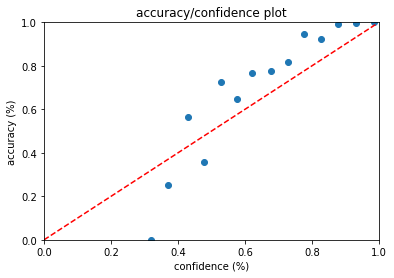

0.023701995611190796


In [ ]:
evaluate_calibration(MNIST_val_set, model, amount=20)